# Homework 2

## Import libraries

In [109]:
import pandas as pd
import time
import matplotlib.pyplot as plt

from itertools import combinations

## Functions

In [110]:
items = set()

"""
Converts a list of transactions into a pandas dataframe with 0s and 1s depending on whether the item is in the transaction or not.
:param transactions: List of transactions (each transaction is a list of items)
"""
def to_dataframe(transactions):
    df = pd.DataFrame(columns=list(items))

    print("Loading transactions into dataframe")
    
    for transaction in transactions:
        # Print progress
        if transactions.index(transaction) % 1000 == 0:
            print("Uploading transaction", transactions.index(transaction))

        df.loc[len(df)] = [1 if item in transaction else 0 for item in items]

    return df
    
"""
Loads the sample dataset
"""
def load_sample_dataset(real=False):
    global items

    # Real dataset
    if real:
        transactions = pd.read_csv('https://raw.githubusercontent.com/matteocirca/data-mining-course-kth-2023/main/hw2/data/dummy_transactions.dat', header=None)
        # transactions = pd.read_csv('data/transactions.dat', header=None)
        transactions = transactions.values.tolist()
        _transactions = []

        for transaction in transactions:
            list_transaction = []
            for item in transaction:
                for single_item in item.rstrip().split(' '):
                    list_transaction.append(single_item)
                    items.add(single_item) # We iterate each element for each of the baskets and add it to the set of items
            _transactions.append(list_transaction)
    else:
        # Dummy dataset
        _transactions = [
            ['Bread', 'Milk'],
            ['Bread', 'Diapers', 'Beer', 'Eggs'],
            ['Milk', 'Diapers', 'Beer', 'Cola'],
            ['Bread', 'Milk', 'Diapers', 'Beer'],
            ['Bread', 'Milk', 'Diapers', 'Cola']
        ]
        for transaction in _transactions:
            for item in transaction:
                items.add(item)

    return _transactions

"""
Iterate through the transactions and count support for each itemset
:param transactions: List of transactions (each transaction is a list of items)
:return: Dictionary of itemsets with their support
"""
def count_itemset(transactions):
    itemset_count = {}

    print("Counting itemset support")

    for transaction in transactions:
        # Print progress
        if transactions.index(transaction) % 1000 == 0:
            print("Transaction", transactions.index(transaction))
        # use combination to get all possible subsets of the itemset
        for i in range(1, len(transaction)+1):
            for item in combinations(transaction, i):
                item = tuple(sorted(item))
                if item in itemset_count:
                    itemset_count[item] += 1
                else:
                    itemset_count[item] = 1

    return itemset_count

"""
Apriori algorithm for finding frequent itemsets
:param transactions: Dataframe of transactions (each transaction is a list of items)
:param min_support: Minimum support threshold
:return: Dictionary of frequent itemsets with their support
"""
def apriori(transactions, list_transactions, min_support, itemset_count=None):

    L = dict() # Candidate k-itemsets

    """
    Gets the possible itemsets for a given size. The function is optimized to avoid generating itemsets that are not possible, 
    meaning that if we have a 2-itemset and we now want to generate 3-itemsets, we only generate the ones that are possible, looking at the 1-itemsets
    that are frequent
    :param transactions: List of transactions (each transaction is a list of items)
    :param size: Size of the itemsets to generate
    """
    def get_new_itemsets(k):
        next_itemsets = set()

        if k == 1:
            for elem in list(transactions.columns):
                next_itemsets.add((elem, )) # Add tuple of one element
        else:
            # We augment the dimension of each of the previous k-1-frequent itemsets with each of the 1-frequent itemsets
            for itemset in L[k-1].keys():
                for item in L[1].keys():
                    if item[0] not in list(itemset):
                        new_itemset = tuple(sorted(list(itemset) + list(item)))
                        next_itemsets.add(new_itemset)

        return next_itemsets


    """
    Calculates the support for each itemset in the list of itemsets. Counting how many times one itemset appears in all transactions.
    :param itemsets: Set of itemsets (each itemset is a tuple of items)
    :return: Dictionary of itemsets with their support
    """
    # Function to calculate support for itemsets
    def calculate_support(itemsets):
        supports = {}

        # For transactions (DataFrame) - version 1 faster
        # for itemset in itemsets:
        #     relevant_df = pd.DataFrame(transactions[list(itemset)]) # Select columns of the itemset
        #     support_count = (relevant_df.sum(axis=1) == len(itemset)).sum() # Count how many rows have 1s everywhere (support)
        #     supports[itemset] = support_count

        # For itemset_count (dict) - version 2 slower
        # for itemset in itemsets:
        #     supports[itemset] = itemset_count[itemset] if itemset in itemset_count else 0

        # scroll rows one by one and check if all items in itemset are present in the row - version 3
        for transaction in list_transactions:
            for itemset in itemsets:
                if set(itemset).issubset(set(transaction)):
                    supports[itemset] = supports.get(itemset, 0) + 1

        return supports

    # =========================================================================================
    # Main part of the algorithm
    k = 1  # Starting with 1-itemsets
    L[k] = dict() # Frequent k-itemsets
    next_itemsets = get_new_itemsets(k) # Candidate k-itemsets
    # print("Next itemsets:", next_itemsets)

    # Loop through each level (single items, pairs, triples, etc.)
    while next_itemsets:
        print("k:", k)
        
        itemset_support = calculate_support(next_itemsets) # Calculate support for each itemset
        # print("Support:", itemset_support)

        L[k] = {itemset: support for itemset, support in itemset_support.items() if support >= min_support} # Select itemsets with support greater or equal to min_support
        print("L[k]:", L[k])

        k += 1 # Next level
        L[k] = dict()
        next_itemsets = get_new_itemsets(k) # Generate candidate itemsets for the next level

    return L



## Runnning on the dataset - Task 1

In [111]:
list_transactions = load_sample_dataset(real=False)

We tried to improve performances by using a dictionary to quickly access an itemset and its support, but it was slower than the summation over the DataFrame.

In [112]:
# itemset_count = count_itemset(list_transactions)
# itemset_count

In [113]:
# Create and save dataset
to_dataframe(list_transactions).to_csv('data/transactions.csv', index=False)

Loading transactions into dataframe
Uploading transaction 0


In [114]:
# Read dataset
df_transactions = pd.read_csv('https://raw.githubusercontent.com/matteocirca/data-mining-course-kth-2023/main/hw2/data/transactions.csv')
# df_transactions = pd.read_csv('data/transactions.csv')
df_transactions

,Eggs,Cola,Diapers,Beer,Milk,Bread
0,0,0,0,0,1,1
1,1,0,1,1,0,1
2,0,1,1,1,1,0
3,0,0,1,1,1,1
4,0,1,1,0,1,1


In [115]:
# Safety check: how many ones are there in the dataset?
df_transactions.sum().sum()

18

In [116]:
timing = [] # Track timing for each dataset size

support = [2, 3, 4, 5, 6, 7, 8, 9, 10] # Support thresholds to test
sizes = [10, 100, 1000, 10000, 100000] # Dataset sizes to test

""" for size in sizes:
    print("Size:", size)
    # TODO: for s in support
    start_time = time.time()
    L = apriori(df_transactions[:size], support[8])
    for k in L.keys():
        print("L[{}]: {}".format(k, L[k]))
    end_time = time.time()
    timing.append((size, end_time - start_time)) """

# print("Size:", size)
# TODO: for s in support
# start_time = time.time()

print(support[2])
L = apriori(df_transactions, list_transactions, 2)
for k in L.keys():
    print("L[{}]: {}".format(k, L[k]))

# end_time = time.time()
# timing.append((size, end_time - start_time))

timing

4
k: 1
L[k]: {('Milk',): 4, ('Bread',): 4, ('Diapers',): 4, ('Beer',): 3, ('Cola',): 2}
k: 2
L[k]: {('Bread', 'Milk'): 3, ('Bread', 'Diapers'): 3, ('Beer', 'Diapers'): 3, ('Beer', 'Bread'): 2, ('Cola', 'Diapers'): 2, ('Beer', 'Milk'): 2, ('Cola', 'Milk'): 2, ('Diapers', 'Milk'): 3}
k: 3
L[k]: {('Beer', 'Bread', 'Diapers'): 2, ('Cola', 'Diapers', 'Milk'): 2, ('Beer', 'Diapers', 'Milk'): 2, ('Bread', 'Diapers', 'Milk'): 2}
k: 4
L[k]: {}
L[1]: {('Milk',): 4, ('Bread',): 4, ('Diapers',): 4, ('Beer',): 3, ('Cola',): 2}
L[2]: {('Bread', 'Milk'): 3, ('Bread', 'Diapers'): 3, ('Beer', 'Diapers'): 3, ('Beer', 'Bread'): 2, ('Cola', 'Diapers'): 2, ('Beer', 'Milk'): 2, ('Cola', 'Milk'): 2, ('Diapers', 'Milk'): 3}
L[3]: {('Beer', 'Bread', 'Diapers'): 2, ('Cola', 'Diapers', 'Milk'): 2, ('Beer', 'Diapers', 'Milk'): 2, ('Bread', 'Diapers', 'Milk'): 2}
L[4]: {}
L[5]: {}


[]

## Performance analysis

As we can see time increases exponentially with the number of items in the itemset. This is due to the fact that the number of itemsets increases exponentially with the number of total items. We optimized the code by using a matrix of 0s and 1s instead of a Dictionary, but still the calculation of the support is the bottleneck of the algorithm.

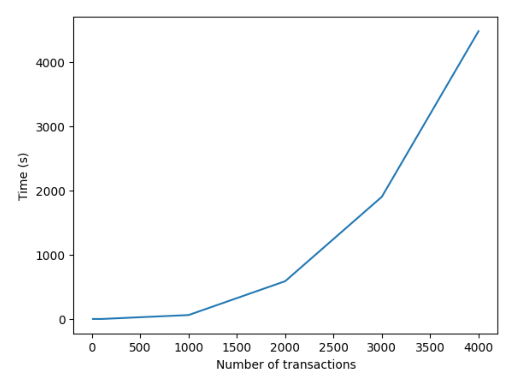

In [117]:
# load the image img/timing.png and show it
img = plt.imread('img/timing.png')
plt.axis('off')
plt.imshow(img)


In [118]:
# Plot timing
# plt.plot([x[0] for x in timing], [x[1] for x in timing])
# plt.xlabel('Number of transactions')
# plt.ylabel('Time (s)')
# plt.show()


## Runnning on the dataset - Task 2

In [119]:
def remove_empty_keys():
    for k in list(L.keys()):
        if not L[k]:
            del L[k]

"""
Generate association rules from frequent itemsets
:param c: Confidence threshold for the association rules
"""
def generate_association_rules(c=0.75):

    association_rules = []

    # Generate association rules, starting from 2-itemsets
    for i in range(2,len(L.keys())+1):
        print("Generating association rules for L[{}]".format(i))
        for itemset in L[i]:
            # print("itemset",itemset)

            for j in range(1,len(itemset)):
                # Generate all possible j-sized combinations of the itemset
                for combination in combinations(itemset, j):
                    # print("Combination:", combination)
                    
                    # A → I \ A formula
                    A = combination # I on the slides
                    B = tuple(sorted(set(itemset) - set(A))) # j on the slides
                    # print("A:", A)
                    # print("B:", B)

                    # Calculate confidence
                    confidence = L[i][itemset]/L[len(A)][A]
                    if(confidence >= c):
                        print("Association rule: {} → {} with confidence {}".format(A, B, confidence))
                        print("===========================================")
                        association_rules.append((A,B,confidence))
    return association_rules
                        

""" 
Finding the interesting association rules with a given threshold t (usually over 0.5)
:param association_rules: List of association rules
:param t: Threshold for the interest
"""
def find_interesting_association_rules(association_rules, t=0.5):
    interesting_rules = []

    for rule in association_rules:
        confidence = rule[2]

        # Extract the columns from the "j"
        itemset = [column for column in rule[1]] # j on the slides 
        
        # Calculate support of j
        relevant_df = pd.DataFrame(df_transactions[list(itemset)]) # Select columns of the itemset
        support_count = (relevant_df.sum(axis=1) == len(itemset)).sum() # Count how many rows have 1s everywhere (support)
        # interest = confidence - Pr[j]
        interest = confidence - support_count/len(df_transactions)

        # Checking positive and negative interest
        if(interest >= t or interest <= -t):
            # print(confidence, support_count, len(df_transactions))
            print("Association rule: {} → {} with interest {}".format(rule[0], rule[1], interest))
            print("===========================================")
            interesting_rules.append((rule[0],rule[1],confidence,interest))
    
    return interesting_rules
  


## (Our) Task 3: Finding association rules with interest above threshold

In [120]:
remove_empty_keys()
association_rules = generate_association_rules()


Generating association rules for L[2]
Association rule: ('Bread',) → ('Milk',) with confidence 0.75
Association rule: ('Milk',) → ('Bread',) with confidence 0.75
Association rule: ('Bread',) → ('Diapers',) with confidence 0.75
Association rule: ('Diapers',) → ('Bread',) with confidence 0.75
Association rule: ('Beer',) → ('Diapers',) with confidence 1.0
Association rule: ('Diapers',) → ('Beer',) with confidence 0.75
Association rule: ('Cola',) → ('Diapers',) with confidence 1.0
Association rule: ('Cola',) → ('Milk',) with confidence 1.0
Association rule: ('Diapers',) → ('Milk',) with confidence 0.75
Association rule: ('Milk',) → ('Diapers',) with confidence 0.75
Generating association rules for L[3]
Association rule: ('Beer', 'Bread') → ('Diapers',) with confidence 1.0
Association rule: ('Cola',) → ('Diapers', 'Milk') with confidence 1.0
Association rule: ('Cola', 'Diapers') → ('Milk',) with confidence 1.0
Association rule: ('Cola', 'Milk') → ('Diapers',) with confidence 1.0
Association

In [121]:
interesting_association_rules = find_interesting_association_rules(association_rules, 0.3)

Association rule: ('Cola',) → ('Diapers', 'Milk') with interest 0.4


## Evaluation of our Apriori-algorithm with built-in library

We tried the built-in function implementation and it turned out to be faster. :)

In [122]:
# Import apriori algorithm and find frequent itesmets from the transactions
from mlxtend.frequent_patterns import apriori

df_transactions = df_transactions.iloc[:,1:]
frequent_itemsets = apriori(df_transactions, min_support=0.1, use_colnames=True)
frequent_itemsets

/Users/matteocirca/opt/anaconda3/envs/test/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.4,(Cola)
1,0.8,(Diapers)
2,0.6,(Beer)
3,0.8,(Milk)
4,0.8,(Bread)
5,0.4,"(Diapers, Cola)"
6,0.2,"(Cola, Beer)"
7,0.4,"(Milk, Cola)"
8,0.2,"(Cola, Bread)"
9,0.6,"(Diapers, Beer)"
